In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# **Data Reading**

In [2]:
datal = pd.read_csv("train.csv")
datal.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


# **Data Exploration and Visualization**

In [3]:
datal.shape

(74111, 29)

In [4]:
data = datal[0:3500]

In [5]:
data.shape

(3500, 29)

In [6]:
data.to_csv('abdata.csv', index=False) 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3500 non-null   int64  
 1   log_price               3500 non-null   float64
 2   property_type           3500 non-null   object 
 3   room_type               3500 non-null   object 
 4   amenities               3500 non-null   object 
 5   accommodates            3500 non-null   int64  
 6   bathrooms               3489 non-null   float64
 7   bed_type                3500 non-null   object 
 8   cancellation_policy     3500 non-null   object 
 9   cleaning_fee            3500 non-null   bool   
 10  city                    3500 non-null   object 
 11  description             3500 non-null   object 
 12  first_review            2689 non-null   object 
 13  host_has_profile_pic    3486 non-null   object 
 14  host_identity_verified  3486 non-null   

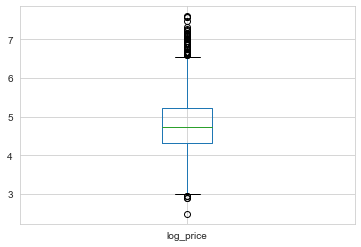

In [8]:
data.log_price.describe() #prediction variable
sns.set_style("whitegrid")
data.log_price.plot.box()

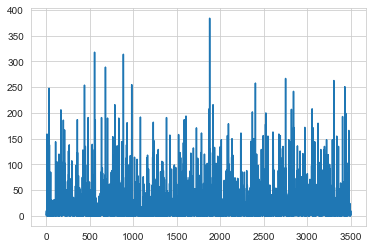

In [9]:
data.number_of_reviews.plot()

In [10]:
#cleaning up the amenities attribute.
amenitiescol = []
amenitiesdict = {}
for item in data.amenities:
  item = item.replace('{','')
  item = item.replace('}','')
  item = item.replace('"','')
  item = item.split(',')
  amenitiescol.append(max(len(item)-1,0))
  for k in item:
    if amenitiesdict.get(k) != None:
      amenitiesdict[k] +=1 
    else:
      amenitiesdict[k] = 1

<BarContainer object of 50 artists>

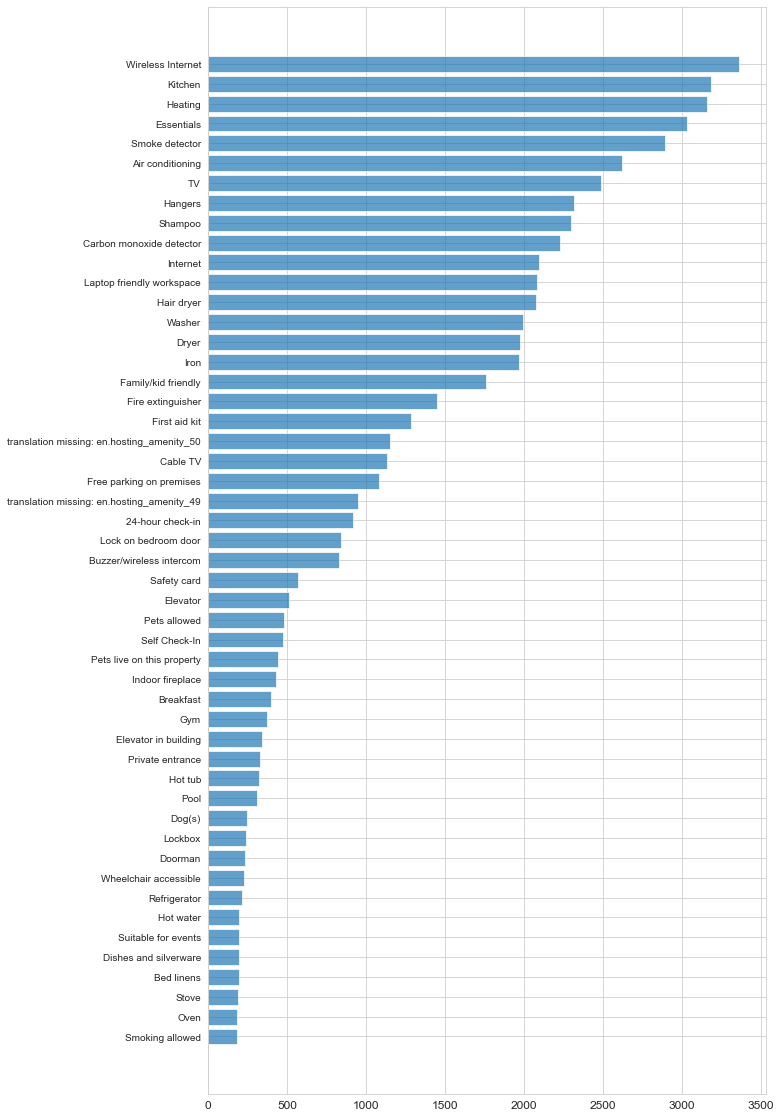

In [11]:
sortedval = sorted(amenitiesdict.values()) # Sort the values
sorteddict = {}
for i in sortedval:
    for k in amenitiesdict.keys():
        if amenitiesdict[k] == i:
            sorteddict[k] = amenitiesdict[k]
            break

keys = sorteddict.keys()

values = sorteddict.values()
plt.figure(figsize=(10,20))
plt.xticks(fontsize=12)
n = 50 #showing sorted 50 of 122 objects
plt.barh(list(keys)[-n:], list(values)[-n:], align='center',alpha=0.7)


# Data Pre-processing 

In [12]:
data.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,3.500000e+03,3500.000000,3500.000000,3489.000000,3500.000000,3500.000000,3500.000000,2650.000000,3495.000000,3495.000000
mean,1.137192e+07,4.797424,3.162286,1.219404,38.495861,-92.057558,19.934286,94.050566,1.252647,1.699571
std,6.129507e+06,0.711778,2.156881,0.536189,3.045918,21.708061,36.241193,8.531850,0.841455,1.215779
min,3.670000e+03,2.484907,1.000000,0.000000,33.343574,-122.508663,0.000000,20.000000,0.000000,1.000000
25%,6.224728e+06,4.317488,2.000000,1.000000,34.149449,-118.346184,1.000000,92.000000,1.000000,1.000000
50%,1.269793e+07,4.744932,2.000000,1.000000,40.667432,-76.979310,5.000000,96.000000,1.000000,1.000000
75%,1.648986e+07,5.220356,4.000000,1.000000,40.742878,-73.952501,22.000000,100.000000,1.000000,2.000000
max,2.119609e+07,7.598399,16.000000,7.500000,42.383869,-70.991861,384.000000,100.000000,8.000000,16.000000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3500 non-null   int64  
 1   log_price               3500 non-null   float64
 2   property_type           3500 non-null   object 
 3   room_type               3500 non-null   object 
 4   amenities               3500 non-null   object 
 5   accommodates            3500 non-null   int64  
 6   bathrooms               3489 non-null   float64
 7   bed_type                3500 non-null   object 
 8   cancellation_policy     3500 non-null   object 
 9   cleaning_fee            3500 non-null   bool   
 10  city                    3500 non-null   object 
 11  description             3500 non-null   object 
 12  first_review            2689 non-null   object 
 13  host_has_profile_pic    3486 non-null   object 
 14  host_identity_verified  3486 non-null   

In [14]:
data.isnull().sum()

id                          0
log_price                   0
property_type               0
room_type                   0
amenities                   0
accommodates                0
bathrooms                  11
bed_type                    0
cancellation_policy         0
cleaning_fee                0
city                        0
description                 0
first_review              811
host_has_profile_pic       14
host_identity_verified     14
host_response_rate        914
host_since                 14
instant_bookable            0
last_review               807
latitude                    0
longitude                   0
name                        0
neighbourhood             320
number_of_reviews           0
review_scores_rating      850
thumbnail_url             398
zipcode                    46
bedrooms                    5
beds                        5
dtype: int64

In [15]:
#dropping unnecessary data
cleandata = data.drop(['id','description','first_review','last_review','host_since','host_has_profile_pic','name','thumbnail_url','zipcode','neighbourhood','latitude','longitude'],axis=1)
cleandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               3500 non-null   float64
 1   property_type           3500 non-null   object 
 2   room_type               3500 non-null   object 
 3   amenities               3500 non-null   object 
 4   accommodates            3500 non-null   int64  
 5   bathrooms               3489 non-null   float64
 6   bed_type                3500 non-null   object 
 7   cancellation_policy     3500 non-null   object 
 8   cleaning_fee            3500 non-null   bool   
 9   city                    3500 non-null   object 
 10  host_identity_verified  3486 non-null   object 
 11  host_response_rate      2586 non-null   object 
 12  instant_bookable        3500 non-null   object 
 13  number_of_reviews       3500 non-null   int64  
 14  review_scores_rating    2650 non-null   

In [16]:
# filling NA with mean of each column of it
cleandata.bathrooms = cleandata.bathrooms.fillna(int(cleandata.bathrooms.mean()))
cleandata.bedrooms = cleandata.bedrooms.fillna(int(cleandata.bedrooms.mean()))
cleandata.beds = cleandata.beds.fillna(int(cleandata.beds.mean()))
cleandata.review_scores_rating = cleandata.review_scores_rating.fillna(cleandata.review_scores_rating.mean())
cleandata.isnull().sum()

log_price                   0
property_type               0
room_type                   0
amenities                   0
accommodates                0
bathrooms                   0
bed_type                    0
cancellation_policy         0
cleaning_fee                0
city                        0
host_identity_verified     14
host_response_rate        914
instant_bookable            0
number_of_reviews           0
review_scores_rating        0
bedrooms                    0
beds                        0
dtype: int64

1.0    2777
2.0     368
1.5     187
2.5      73
3.0      31
3.5      27
4.0      12
0.0      10
0.5       5
4.5       4
5.0       3
5.5       2
7.5       1
Name: bathrooms, dtype: int64

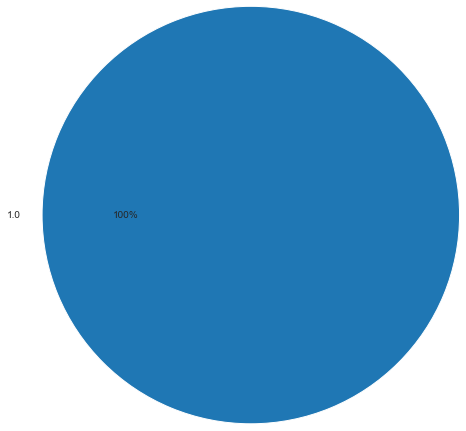

In [17]:
#displaying pie chart of bathroom having greater than 500 counts for visible representation
bathroomscounts = cleandata.bathrooms.value_counts()
bathroomscounts [bathroomscounts >500].plot.pie(autopct='%1.0f%%',radius=2.4)
bathroomscounts

1.0    2347
2.0     545
0.0     333
3.0     193
4.0      56
5.0      17
6.0       6
7.0       2
8.0       1
Name: bedrooms, dtype: int64

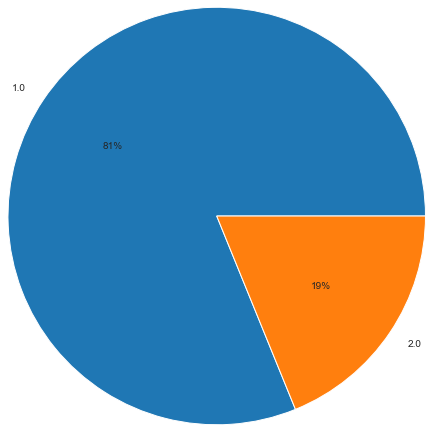

In [18]:
#displaying pie chart of bedrooms having greater than 500 counts for visible representation
bedroomscounts = cleandata.bedrooms.value_counts()
bedroomscounts [bedroomscounts >500].plot.pie(autopct='%1.0f%%',radius=2.4)
bedroomscounts

1.0     2117
2.0      833
3.0      290
4.0      147
5.0       58
6.0       29
7.0        8
8.0        6
10.0       5
12.0       2
13.0       2
11.0       1
9.0        1
16.0       1
Name: beds, dtype: int64

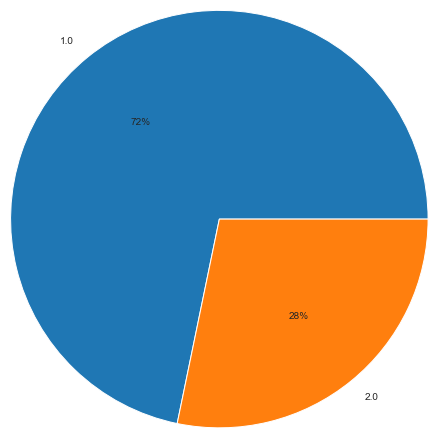

In [19]:
#displaying pie chart of beds having greater than 500 counts for visible representation
bedscounts = cleandata.beds.value_counts()
bedscounts [bedscounts >500].plot.pie(autopct='%1.0f%%',radius=2.4)
bedscounts

In [20]:
# Fixing host response rate and change its value to the correct data type
cleandata.host_response_rate = cleandata.host_response_rate.apply(lambda x: int(x[:len(x)-1])/100 if isinstance(x,str) else x)
cleandata.host_response_rate

0       NaN
1       1.0
2       1.0
3       NaN
4       1.0
       ... 
3495    NaN
3496    1.0
3497    NaN
3498    1.0
3499    1.0
Name: host_response_rate, Length: 3500, dtype: float64

In [21]:
cleandata.host_response_rate = cleandata.host_response_rate.fillna(cleandata.host_response_rate.mean())
cleandata.host_response_rate

0       0.942285
1       1.000000
2       1.000000
3       0.942285
4       1.000000
          ...   
3495    0.942285
3496    1.000000
3497    0.942285
3498    1.000000
3499    1.000000
Name: host_response_rate, Length: 3500, dtype: float64

In [22]:
# Changing all boolean objects to 0/1
cleandata.host_identity_verified = cleandata.host_identity_verified.apply(lambda x: True if x=='t' else False)
cleandata.instant_bookable = cleandata.instant_bookable.apply(lambda x: True if x=='t' else False)

In [23]:
cleandata["cleaning_fee"] = cleandata["cleaning_fee"].astype(int)
cleandata["host_identity_verified"] = cleandata["host_identity_verified"].astype(int)
cleandata["instant_bookable"] = cleandata["instant_bookable"].astype(int)

In [24]:
cleandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               3500 non-null   float64
 1   property_type           3500 non-null   object 
 2   room_type               3500 non-null   object 
 3   amenities               3500 non-null   object 
 4   accommodates            3500 non-null   int64  
 5   bathrooms               3500 non-null   float64
 6   bed_type                3500 non-null   object 
 7   cancellation_policy     3500 non-null   object 
 8   cleaning_fee            3500 non-null   int32  
 9   city                    3500 non-null   object 
 10  host_identity_verified  3500 non-null   int32  
 11  host_response_rate      3500 non-null   float64
 12  instant_bookable        3500 non-null   int32  
 13  number_of_reviews       3500 non-null   int64  
 14  review_scores_rating    3500 non-null   

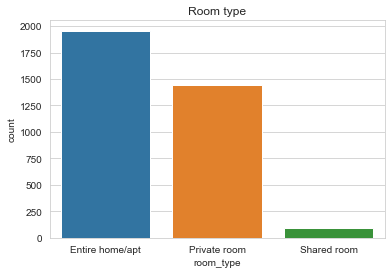

In [25]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
sns.countplot(cleandata['room_type'])
plt.title('Room type')
plt.show()

In [26]:
cleandata.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [27]:
cleandata.room_type = cleandata.room_type.apply(lambda x: 3 if x=='Entire home/apt' else 2 if x=='Private room' else 1)
cleandata.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_response_rate,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds
0,5.010635,Apartment,3,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,1,NYC,1,0.942285,0,2,100.000000,1.0,1.0
1,5.129899,Apartment,3,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,1,NYC,0,1.000000,1,6,93.000000,3.0,3.0
2,4.976734,Apartment,3,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,1,NYC,1,1.000000,1,10,92.000000,1.0,3.0
3,6.620073,House,3,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,1,SF,1,0.942285,0,0,94.050566,2.0,2.0
4,4.744932,Apartment,3,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,1,DC,1,1.000000,1,4,40.000000,0.0,1.0


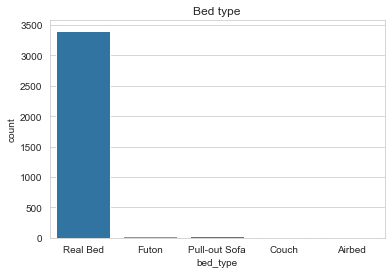

In [28]:
sns.countplot(cleandata['bed_type'])
plt.title('Bed type')
plt.show()

In [29]:
cleandata.bed_type.unique()

array(['Real Bed', 'Futon', 'Pull-out Sofa', 'Couch', 'Airbed'],
      dtype=object)

In [30]:
cleandata.bed_type = cleandata.bed_type.apply(lambda x: 2 if x=='Real Bed' else 1)

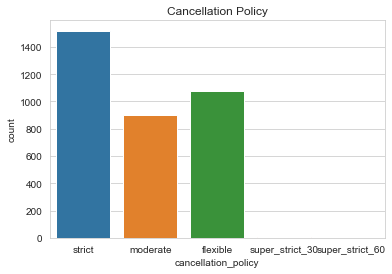

In [31]:
sns.countplot(cleandata['cancellation_policy'])
plt.title('Cancellation Policy')
plt.show()

In [32]:
cleandata.cancellation_policy.unique()

array(['strict', 'moderate', 'flexible', 'super_strict_30',
       'super_strict_60'], dtype=object)

In [33]:
cleandata.cancellation_policy = cleandata.cancellation_policy.apply(lambda x: 4 if x=='flexible' else 3 if x=='moderate' else 2 if x=='strict' else 1)

In [34]:
cleandata.city.unique()

array(['NYC', 'SF', 'DC', 'LA', 'Chicago', 'Boston'], dtype=object)

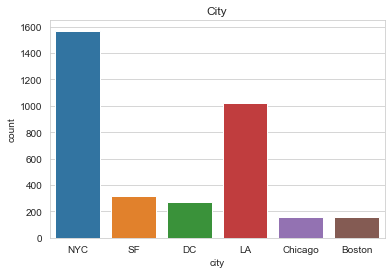

In [35]:
sns.countplot(cleandata['city'])
plt.title('City')
plt.show()

In [36]:
cleandata = pd.concat([cleandata, pd.get_dummies(cleandata['city'], prefix='city')],axis=1)

In [37]:
cleandata = cleandata.drop(['city'],axis=1)
cleandata.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_identity_verified,...,number_of_reviews,review_scores_rating,bedrooms,beds,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF
0,5.010635,Apartment,3,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,2,2,1,1,...,2,100.000000,1.0,1.0,0,0,0,0,1,0
1,5.129899,Apartment,3,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,2,2,1,0,...,6,93.000000,3.0,3.0,0,0,0,0,1,0
2,4.976734,Apartment,3,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,2,3,1,1,...,10,92.000000,1.0,3.0,0,0,0,0,1,0
3,6.620073,House,3,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,2,4,1,1,...,0,94.050566,2.0,2.0,0,0,0,0,0,1
4,4.744932,Apartment,3,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,2,3,1,1,...,4,40.000000,0.0,1.0,0,0,1,0,0,0


In [38]:
cleandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               3500 non-null   float64
 1   property_type           3500 non-null   object 
 2   room_type               3500 non-null   int64  
 3   amenities               3500 non-null   object 
 4   accommodates            3500 non-null   int64  
 5   bathrooms               3500 non-null   float64
 6   bed_type                3500 non-null   int64  
 7   cancellation_policy     3500 non-null   int64  
 8   cleaning_fee            3500 non-null   int32  
 9   host_identity_verified  3500 non-null   int32  
 10  host_response_rate      3500 non-null   float64
 11  instant_bookable        3500 non-null   int32  
 12  number_of_reviews       3500 non-null   int64  
 13  review_scores_rating    3500 non-null   float64
 14  bedrooms                3500 non-null   

In [39]:
cleandata['amenities_count'] = pd.Series(amenitiescol)
cleandata = cleandata.drop(['amenities'], axis=1)
cleandata.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_identity_verified,host_response_rate,...,review_scores_rating,bedrooms,beds,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,amenities_count
0,5.010635,Apartment,3,3,1.0,2,2,1,1,0.942285,...,100.000000,1.0,1.0,0,0,0,0,1,0,8
1,5.129899,Apartment,3,7,1.0,2,2,1,0,1.000000,...,93.000000,3.0,3.0,0,0,0,0,1,0,14
2,4.976734,Apartment,3,5,1.0,2,3,1,1,1.000000,...,92.000000,1.0,3.0,0,0,0,0,1,0,18
3,6.620073,House,3,4,1.0,2,4,1,1,0.942285,...,94.050566,2.0,2.0,0,0,0,0,0,1,14
4,4.744932,Apartment,3,2,1.0,2,3,1,1,1.000000,...,40.000000,0.0,1.0,0,0,1,0,0,0,11


In [40]:
cleandata.review_scores_rating = cleandata.review_scores_rating/100

In [41]:
cleandata.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_identity_verified,host_response_rate,...,review_scores_rating,bedrooms,beds,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,amenities_count
0,5.010635,Apartment,3,3,1.0,2,2,1,1,0.942285,...,1.000000,1.0,1.0,0,0,0,0,1,0,8
1,5.129899,Apartment,3,7,1.0,2,2,1,0,1.000000,...,0.930000,3.0,3.0,0,0,0,0,1,0,14
2,4.976734,Apartment,3,5,1.0,2,3,1,1,1.000000,...,0.920000,1.0,3.0,0,0,0,0,1,0,18
3,6.620073,House,3,4,1.0,2,4,1,1,0.942285,...,0.940506,2.0,2.0,0,0,0,0,0,1,14
4,4.744932,Apartment,3,2,1.0,2,3,1,1,1.000000,...,0.400000,0.0,1.0,0,0,1,0,0,0,11


In [42]:
label_encoder = preprocessing.LabelEncoder()
cleandata['property_type']= label_encoder.fit_transform(cleandata['property_type']) 
cleandata.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_identity_verified,host_response_rate,...,review_scores_rating,bedrooms,beds,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,amenities_count
0,5.010635,0,3,3,1.0,2,2,1,1,0.942285,...,1.000000,1.0,1.0,0,0,0,0,1,0,8
1,5.129899,0,3,7,1.0,2,2,1,0,1.000000,...,0.930000,3.0,3.0,0,0,0,0,1,0,14
2,4.976734,0,3,5,1.0,2,3,1,1,1.000000,...,0.920000,1.0,3.0,0,0,0,0,1,0,18
3,6.620073,12,3,4,1.0,2,4,1,1,0.942285,...,0.940506,2.0,2.0,0,0,0,0,0,1,14
4,4.744932,0,3,2,1.0,2,3,1,1,1.000000,...,0.400000,0.0,1.0,0,0,1,0,0,0,11


In [43]:
cleandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               3500 non-null   float64
 1   property_type           3500 non-null   int32  
 2   room_type               3500 non-null   int64  
 3   accommodates            3500 non-null   int64  
 4   bathrooms               3500 non-null   float64
 5   bed_type                3500 non-null   int64  
 6   cancellation_policy     3500 non-null   int64  
 7   cleaning_fee            3500 non-null   int32  
 8   host_identity_verified  3500 non-null   int32  
 9   host_response_rate      3500 non-null   float64
 10  instant_bookable        3500 non-null   int32  
 11  number_of_reviews       3500 non-null   int64  
 12  review_scores_rating    3500 non-null   float64
 13  bedrooms                3500 non-null   float64
 14  beds                    3500 non-null   

In [44]:
cleandata.isnull().sum()

log_price                 0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
host_identity_verified    0
host_response_rate        0
instant_bookable          0
number_of_reviews         0
review_scores_rating      0
bedrooms                  0
beds                      0
city_Boston               0
city_Chicago              0
city_DC                   0
city_LA                   0
city_NYC                  0
city_SF                   0
amenities_count           0
dtype: int64

In [45]:
cleandata.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_identity_verified,host_response_rate,...,review_scores_rating,bedrooms,beds,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,amenities_count
0,5.010635,0,3,3,1.0,2,2,1,1,0.942285,...,1.000000,1.0,1.0,0,0,0,0,1,0,8
1,5.129899,0,3,7,1.0,2,2,1,0,1.000000,...,0.930000,3.0,3.0,0,0,0,0,1,0,14
2,4.976734,0,3,5,1.0,2,3,1,1,1.000000,...,0.920000,1.0,3.0,0,0,0,0,1,0,18
3,6.620073,12,3,4,1.0,2,4,1,1,0.942285,...,0.940506,2.0,2.0,0,0,0,0,0,1,14
4,4.744932,0,3,2,1.0,2,3,1,1,1.000000,...,0.400000,0.0,1.0,0,0,1,0,0,0,11


In [46]:
y= cleandata['log_price']
cols = [col for col in cleandata.columns if col not in ['log_price']]
X= cleandata[cols]

In [47]:
from sklearn.ensemble import RandomForestRegressor #for feature importance
model = RandomForestRegressor()
model.fit(X,y)

RandomForestRegressor()

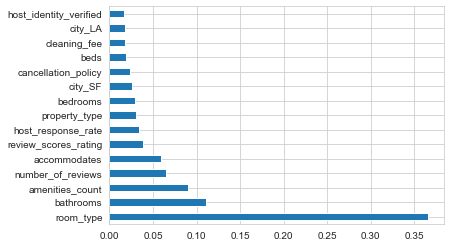

In [48]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [49]:
#Removing unneeded features
cleandata = cleandata.drop(['bed_type','instant_bookable'],axis=1)

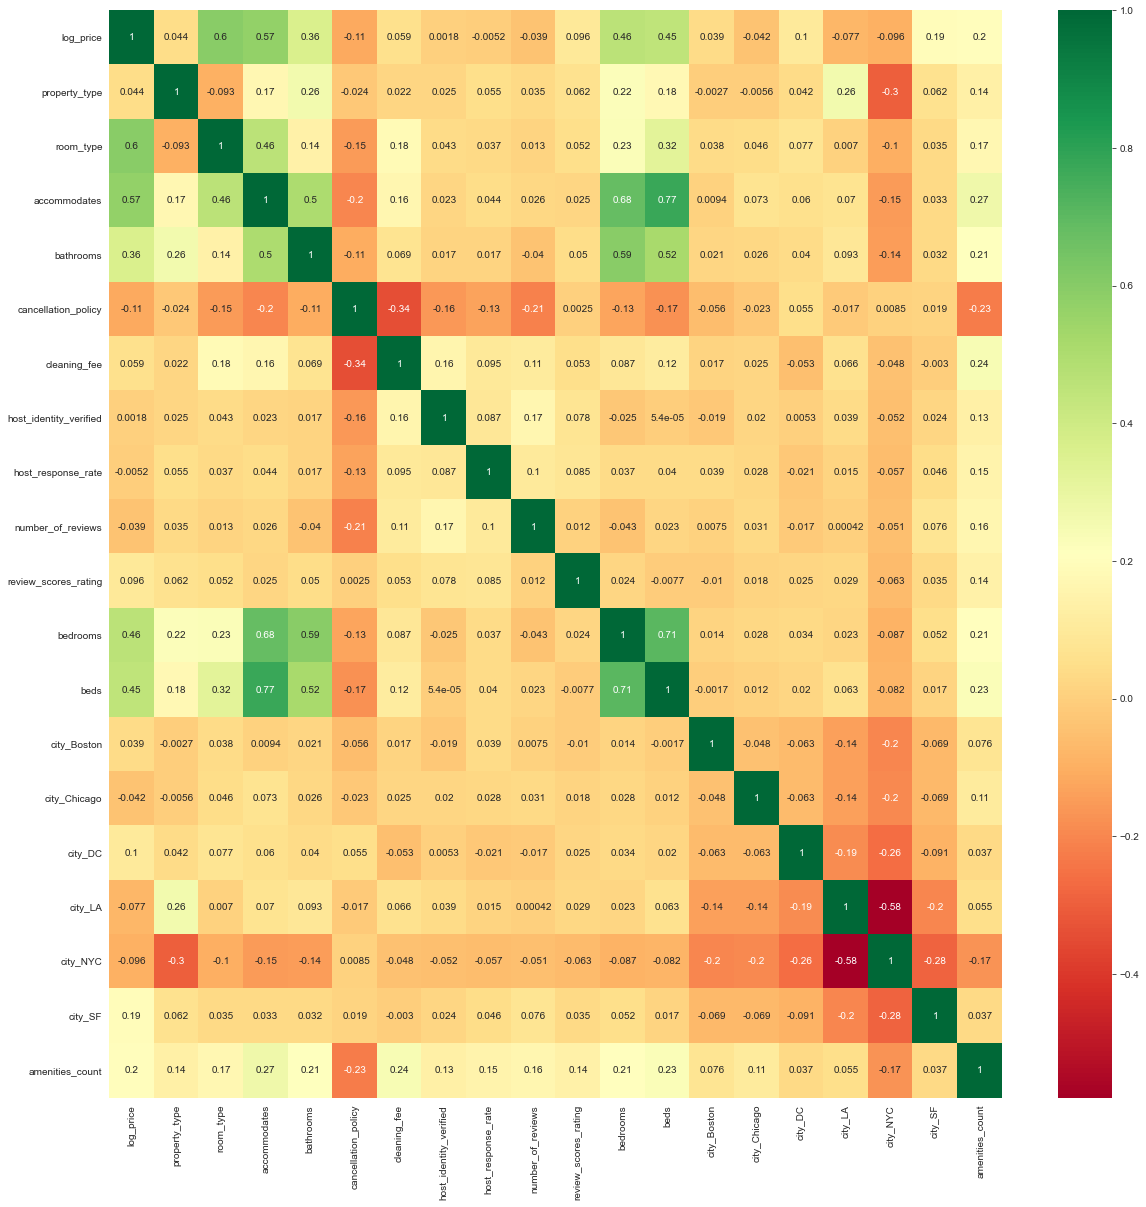

In [50]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = cleandata.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(cleandata[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# **Model selection, Training and Results**

In [51]:
copydata = cleandata

In [52]:
# Spliting the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
train, test  = train_test_split(copydata, test_size=0.2,random_state = 42)
X_train = train.drop(['log_price'], axis=1)
y_train = train.log_price
X_test = test.drop(['log_price'], axis=1) 
y_test = test.log_price

In [53]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 1650 to 2213
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           700 non-null    int32  
 1   room_type               700 non-null    int64  
 2   accommodates            700 non-null    int64  
 3   bathrooms               700 non-null    float64
 4   cancellation_policy     700 non-null    int64  
 5   cleaning_fee            700 non-null    int32  
 6   host_identity_verified  700 non-null    int32  
 7   host_response_rate      700 non-null    float64
 8   number_of_reviews       700 non-null    int64  
 9   review_scores_rating    700 non-null    float64
 10  bedrooms                700 non-null    float64
 11  beds                    700 non-null    float64
 12  city_Boston             700 non-null    uint8  
 13  city_Chicago            700 non-null    uint8  
 14  city_DC                 700 non-null  

In [54]:
X_test.head()

,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,host_identity_verified,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,beds,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,amenities_count
1650,0,3,4,1.0,2,1,1,1.000000,42,1.000000,2.0,3.0,0,1,0,0,0,0,24
2456,12,2,1,1.0,3,1,1,0.942285,0,0.940506,1.0,1.0,0,0,0,1,0,0,23
2232,18,2,2,2.0,4,1,1,1.000000,2,1.000000,3.0,1.0,0,0,0,1,0,0,2
1945,0,3,3,1.0,4,1,1,1.000000,0,0.940506,1.0,1.0,0,0,0,1,0,0,9
309,12,2,2,1.0,4,0,1,0.942285,0,0.940506,1.0,1.0,0,0,0,0,0,1,16


In [55]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 15)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10,15]

In [56]:
# grid to search for best hyperparameters
grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
       'min_samples_leaf': min_samples_leaf}
print(grid)

{'n_estimators': [100, 157, 215, 273, 331, 389, 447, 505, 563, 621, 678, 736, 794, 852, 910, 968, 1026, 1084, 1142, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 8, 11, 14, 17, 21, 24, 27, 30, 33, 37, 40, 43, 46, 50], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10, 15]}


# XGB

In [57]:
import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred

array([5.080589 , 4.521308 , 3.6936655, 4.748223 , 5.424195 , 5.111223 ,
       5.33459  , 4.857649 , 4.909903 , 3.8803957, 6.5263233, 5.315465 ,
       4.9963684, 5.292164 , 3.7202554, 5.1638827, 5.1595297, 3.7235668,
       4.687091 , 4.466408 , 5.095192 , 4.6845465, 5.4530134, 6.028625 ,
       4.678134 , 4.4124584, 5.047471 , 4.4271364, 4.5443716, 5.0112066,
       4.158734 , 5.012745 , 5.701499 , 5.1647186, 4.190836 , 4.021877 ,
       4.436553 , 5.103493 , 4.5645833, 3.7453198, 4.1742435, 6.8572273,
       4.655214 , 5.412497 , 4.1279626, 4.470032 , 5.9344225, 5.550548 ,
       4.1257877, 5.1652637, 4.1215134, 5.149923 , 4.4500732, 4.8939214,
       4.0885544, 5.037656 , 4.809095 , 4.783032 , 5.2679205, 5.0801425,
       4.7399864, 4.6457825, 4.8129883, 4.790628 , 5.4336643, 4.6378627,
       5.6184564, 5.762488 , 4.687587 , 4.5461354, 4.662434 , 4.986501 ,
       4.515933 , 5.13454  , 5.652131 , 4.966433 , 4.483332 , 4.479053 ,
       3.9976707, 4.6104093, 5.0514197, 4.1117835, 

In [58]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.38177506176952775
MSE: 0.24331701456539065
RMSE: 0.49327174515209227


In [59]:
metrics.r2_score(y_test, pred)

0.5624115660831895

# Random Forest

In [60]:
model = RandomForestRegressor() 
rfr = RandomizedSearchCV(estimator = model,
                        param_distributions=grid,
                        n_iter=15,
                       scoring= 'neg_mean_squared_error',
                        cv=5,verbose = 2,
                        random_state = 42,n_jobs = 1) 
rfr.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END max_depth=27, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=678; total time=   3.1s
[CV] END max_depth=27, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=678; total time=   3.1s
[CV] END max_depth=27, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=678; total time=   3.0s
[CV] END max_depth=27, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=678; total time=   3.1s
[CV] END max_depth=27, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=678; total time=   2.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estima

[CV] END max_depth=50, max_features=auto, min_samples_leaf=15, min_samples_split=5, n_estimators=273; total time=   1.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=15, min_samples_split=5, n_estimators=273; total time=   1.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=15, min_samples_split=5, n_estimators=273; total time=   0.9s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1026; total time=   2.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1026; total time=   2.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1026; total time=   2.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1026; total time=   2.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1026; total time=   2.3s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=15, n_jobs=1,
                   param_distributions={'max_depth': [5, 8, 11, 14, 17, 21, 24,
                                                      27, 30, 33, 37, 40, 43,
                                                      46, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 157, 215, 273,
                                                         331, 389, 447, 505,
                                                         563, 621, 678, 736,
                                                         794, 852, 910, 968,
                                                         1026, 1084, 1142,
                  

In [61]:
bestrfr=rfr.best_estimator_

In [62]:
ypred = bestrfr.predict(X_test)
ypred

array([4.92550318, 4.41614906, 4.46869984, 4.76840399, 5.11468733,
       5.06374353, 5.2868437 , 5.02930888, 5.02944128, 3.9876978 ,
       6.12087502, 5.19030036, 4.93011649, 5.23286214, 3.83295993,
       5.11213264, 5.14971494, 3.98599776, 4.90001084, 4.39194745,
       4.98381303, 4.89677471, 5.58549903, 5.88996858, 4.57943921,
       4.41587639, 5.15236298, 4.23356952, 4.70824564, 5.08689459,
       4.18457579, 5.08367212, 5.62436308, 5.44426609, 4.31349255,
       4.14674892, 4.6133477 , 5.06166046, 4.41208129, 4.02627276,
       4.42231077, 6.67752097, 4.36615884, 5.18850843, 4.57107919,
       4.63857635, 5.37675112, 5.42917534, 4.44497127, 5.1193304 ,
       4.08537365, 5.15256044, 4.59737692, 4.88147541, 4.19761788,
       4.973703  , 4.74595216, 4.68884356, 5.30947699, 4.95447387,
       4.64256833, 4.72298911, 4.97770195, 5.05003648, 5.21807046,
       4.68955536, 5.56108452, 5.58463715, 4.38917426, 4.32566778,
       5.06071488, 4.82265123, 4.38426459, 5.18388427, 5.88786

In [63]:
print('MAE:', metrics.mean_absolute_error(y_test, ypred))
print('MSE:', metrics.mean_squared_error(y_test, ypred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred)))

MAE: 0.36653181314298716
MSE: 0.22796033459807427
RMSE: 0.4774519186243514


In [64]:
metrics.r2_score(y_test, ypred)

0.5900294683867445

# Pickle to save model

In [65]:
import pickle
file = open("file.pkl", "wb") # opening a new file in write mode
pickle.dump(bestrfr, file) # dumping created rf model into a pickle file